# Context

At the time of writing, it is 13/06/2020 and I have just finished my Part III Mathematics exams at the University of Cambridge, bringing to an end my four years of studying Mathematics at Cambridge.

Note: this historical context is primarily for future me to look back on.

# Objective

Computer vision is not my background and neither is computer science. But, intrigued by the hype surrounding 'deep learning', I've recently been learning about the subject in the context of computer vision.

I decided to apply some of the ideas I've learned by tackling a real-world task. It's all fine and well learning in the confines of an online course, specifically curated to hide away the ugly details (like data wrangling), but there's nothing quite like going out into the wild and getting your hands dirty! 

There appears to be a variety of standard 'first projects' out there for newbies like me: classifying hand-written digits, or playing cards, or cats versus dogs... Rather than just follow one of the countless tutorials that treat these tasks, I decided to build a model for identifying trees in satellite images (shoutout to the environment!). 

This has been a great learning experience. I've learned a fair bit about computer vision, remote sensing and satellite imaging along the way, as well as the process of training neural networks and, saving the best (ha!) for last, data wrangling.

## Data

I use data from an old [Kaggle challenge](https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection). The challenge is to identify various types of objects - for example, trees, vehicles, buildings - in satellite imagery.  

Below, I summarise some key points relating to the data that are relevant to my objective of identifying trees. Note that I'm a complete newbie when it comes to remote sensing and satellite imaging, so I make no guarantee that my remarks on technical points are fully accurate!

### Image Data

*   Each image captures a 1km x 1km region on the ground.
*   There are 425 test regions and 25 train regions. 
*   For each such 1km x 1km region, there are 4 types of images provided: Multispectral, Short-Wave Infra-Red (SWIR), Panchromatic, and 3-band.
*   These 4 types of images differ in 3 key respects: 1) the *spectral band(s)* of each image, 2) the *spatial resolution* of each image, and 3) the *dynamic range* of each image.
*   A *spectral band* is a range of wavelengths of light, e.g. 400-450 nanometres (nm). The Multispectral images are made up of 8 channels (just as a standard RGB image is made up of 3 channels, Red, Green and Blue), each with different spectral bands - its first channel, named 'Coastal', corresponds to the 400-450 nm spectral band. Similarly, the SWIR, Panchromatic, and 3-band images are made up of 8, 1 and 3 channels respectively. The specific spectral bands that the Multispectral, SWIR and Panchromatic channels correspond to can be found [here](http://content.satimagingcorp.com.s3.amazonaws.com/media/pdf/WorldView-3-PDF-Download.pdf) - the 3-band images are a bit of a special case that I touch on a few bullet points down.
*   The *spectral resolution* of the images refers to the area that each pixel represents. The spectral resolution varies by the image type (Multispectral, SWIR, etc) - the full details can be found [here](http://content.satimagingcorp.com.s3.amazonaws.com/media/pdf/WorldView-3-PDF-Download.pdf) or in the Kaggle challenge description. When we speak of *low* spatial resolution, we mean each pixel represents a *large* area on the ground, and vice versa.
*   In general, there is a tradeoff between spatial resolution and the range of wavelengths captured (i.e. spectral band). The narrower the spectral band, the more difficult it is to capture images at a high resolution. The Panchromatic images are able to obtain a very high spatial resolution (so can capture fine details on the ground) as a result of capturing a wide range of wavelengths. [Here's](https://gis.stackexchange.com/questions/113896/panchromatic-image-association-with-high-spatial-resolution#:~:text=Panchromatic%20images%20are%20created%20when,detect%20a%20difference%20in%20brightness.) a better explanation. For the layman (like myself): these images offer a great degree of spatial precision but sacrifice colour information - they're kind of like black-and-white images.
*   The spatial resolution of the Multispectral images is about 4x worse than the Panchromatic images, and the SWIR resolution is about 6x worse than the Multispectral.
*   The 3-band images are essentially 'standard' RGB images, *at the super-high resolution of the Panchromatic images*. These 3-band images are actually constructed from the Red, Green and Blue bands of the Multispectral images, together with the Panchromatic images, via a process known as *panchromatic sharpening*. 
*  The *dynamic range* of the images refers to the amount of memory allocated to each pixel per channel. Standard RGB images have a dynamic range of 8 bits. In our case, the dynamic ranges are 11, 14, 11, and 11 bits per pixel, for Multispectral, SWIR, Panchromatic and 3-band images respectively. 

### Tree Data

*   For each 1km x 1km train region, the regions corresponding to trees are specified by a list of polygons, specified in Well-Known Text (WKT) format.
*   This data make up the 'ground-truths' that will be used in training my model (in the supervised learning paradigm).

### Data I Use

*   With any sort of modelling task, I tend to start simple and iteratively add complexity. To that end, I began by using only the Multispectral and SWIR images. Thus, I throw away the extra spatial precision offered by the 3-band/Panchromatic images. An obvious potential improvement to my analysis, then, is to incorporate this information. I haven't gotten round to trying this yet, so we're stuck with the Multispectral/SWIR images for the time being.

### Directory Structure

For anyone interested in following along with or replicating my analysis, I specify below the directory structure I assume in this notebook for the raw data files (which are obtained from the Kaggle challenge).



```
raw_data_dir
+-- sixteen_band 
|   +-- 6010_0_0_A.tif
|   +-- 6010_0_0_M.tif
|   +-- 6010_0_0_P.tif 
|   +-- 6010_0_1_A.tif
|   ...
+-- three_band
|   +-- 6010_0_0.tif
|   +-- 6010_0_1.tif
|   ...
+-- train_wkt_v4.csv
+-- grid_sizes.csv
```


# Imports

In [0]:
import cv2  # computer vision library 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle 

# for dealing with .tif and .tiff image files
import tifffile as tiff  

# for dealing with WKT format
from shapely.wkt import loads as wkt_loads  
import shapely.affinity as affinity

# for plotting polygons
from descartes import PolygonPatch

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

# Querying Data

Various functions for querying the data in its raw form.

In [0]:
class DataReader():

    def __init__(self, raw_data_dir='/content/drive/My Drive/tree_detection'):
        """
        Class to query the data in its raw form.

        Parameters
        ----------
        root_dir : str
            Path to the root directory containing the data.
        """
        self.raw_data_dir = raw_data_dir
        self._grid_sizes = pd.read_csv(
            f'{self.raw_data_dir}/grid_sizes.csv', 
            names=['ImageId', 'Xmax', 'Ymin'],
            skiprows=1
        ) 
        self._train_wkt = pd.read_csv(
            f'{self.raw_data_dir}/train_wkt_v4.csv'
        )
        self.train_img_ids = sorted(self._train_wkt.ImageId.unique())
        self.img_ids = sorted(self._grid_sizes.ImageId.unique())
        self.test_img_ids = sorted(
            [img_id for img_id in self.img_ids if img_id not in self.train_img_ids]
            )
    
    def get_img(self, img_id, img_type='3', channel_as_last_dim=True):
        """
        Retrieve a particular image, in numpy array form.
        
        Parameters
        ----------
        img_id : str
            8-character ID characterising the 1km x 1km region.
        img_type : str
            Options are '3', 'M', 'A', or 'P', corresponding to 3-band, 
            Multispectral, SWIR or Panchromatic image.
        channel_as_last_dim : bool
            If True, the final dimension of the numpy array representing the 
            image corresponds to the channel number. Else, the first dimension
            corresponds to the channel number.

        Returns
        -------
        img : numpy.ndarray
            The image in array form.
        """
        assert img_type in ['3', 'M', 'A', 'P'], 'Invalid img_type'
        if img_type == '3':
            img = tiff.imread(
                f'{self.raw_data_dir}/three_band/{img_id}.tif'
                )
        else:
            img = tiff.imread(
                f'{self.raw_data_dir}/sixteen_band/{img_id}_{img_type}.tif'
                )
        if not channel_as_last_dim:
            return img  # shape (num_channels, Height, Width)
        elif img_type == 'P':
            return img  # shape (Height, Width)
        else:
            img = np.rollaxis(img, 0, 3) # shape (Height, Width, num_channels)
            return img

    def get_img_H_W(self, img_id, img_type='3'):
        """
        Retrieve the height and width of a particular image, in pixels. 
        
        Parameters
        ----------
        img_id : str
            8-character ID characterising the 1km x 1km region.
        img_type : str
            Options are '3', 'M', 'A', or 'P', corresponding to 3-band, 
            Multispectral, SWIR or Panchromatic image.

        Returns
        -------
        (H, W) : tuple
            The height and width in pixels.
        """
        img = self.get_img(img_id, img_type, rolled=True)
        H, W = img.shape[0], img.shape[1]
        return H, W

    def get_xmax_ymin(self, img_id):
        """
        Retrieve the xmax and ymin numbers in the grid_sizes.csv file. 
        These are essential for making sense of the polygons specifying the
        tree regions.
        
        Parameters
        ----------
        img_id : str
            8-character ID characterising the 1km x 1km region.

        Returns
        -------
        (xmax, ymin) : tuple
            xmax in the range [0, 1], ymin in the range [-1, 0].
        """
        df = self._grid_sizes[self._grid_sizes.ImageId == img_id]
        xmax, ymin = df.iloc[0, 1:].astype(float)
        return xmax, ymin
    
    def get_multipoly(self, img_id):
        """
        Retrieve the MultiPolygon object describing the tree regions in a
        particular 1km x 1km region.
        
        Parameters
        ----------
        img_id : str
            8-character ID characterising the 1km x 1km region.

        Returns
        -------
        multipoly : shapely.geometry.multipolygon.MultiPolygon
        """
        assert img_id in self.train_img_ids, 'Image ID must be in the training set'
        df = self._train_wkt[self._train_wkt.ImageId == img_id]
        # 5 is the ClassType corresponding to Trees
        multipoly_str = df[df.ClassType == 5].MultipolygonWKT.values[0]
        # converting string to MultiPolygon
        multipoly = wkt_loads(multipoly_str)  
        return multipoly 

In [0]:
data_reader = DataReader()

## Visualising Images

Here, I display (portions of) 4 randomly chosen 1km x 1km regions. Next, I do the same for 4 randomly chosen *train* regions, with the trees highlighted.

I adjust the contrasts of the (RGB) images to make them clearer to the human eye.

In [0]:
def process_rgb_img_for_visualisation(rgb_img):
    processed_rgb_img = np.zeros_like(rgb_img)
    for i in range(3):
        band = rgb_img[:, :, i]
        upper = np.percentile(band, 98)
        lower = np.percentile(band, 2)
        band = (np.clip(band, lower, upper) - lower)/(upper - lower) * 255
        processed_rgb_img[:, :, i] = band
    return processed_rgb_img.astype(np.uint8)

Plotting 200m x 200m patches of 4 randomly chosen regions.

In [0]:
np.random.seed(0)
img_ids = np.random.choice(data_reader.img_ids, 4, replace=False)

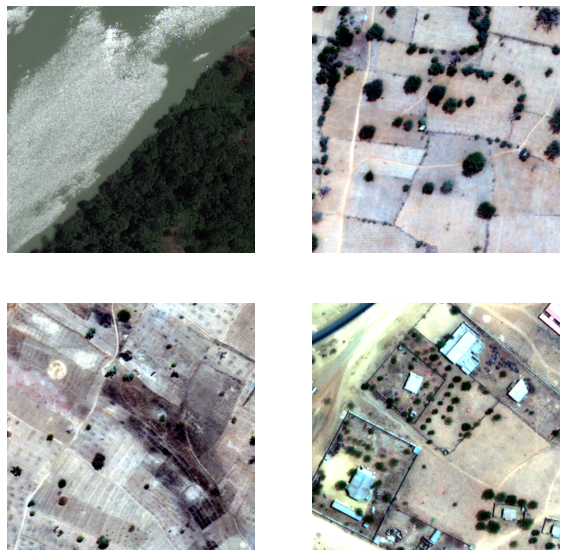

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i in range(2):
    for j in range(2):
        ax = axes[i][j]
        img_id = img_ids[2*i+j]
        rgb_img = data_reader.get_img(img_id, '3')
        processed_rgb_img = process_rgb_img_for_visualisation(rgb_img)
        ax.imshow(processed_rgb_img, extent=(0, 1, 1, 0), origin='upper')
        ax.set_axis_off()
        ax.set_xlim([0, 0.2])
        ax.set_ylim([0, 0.2])

fig.show()

Plotting 200m x 200m patches of 4 randomly chosen train regions, with trees enclosed in red.

In [0]:
np.random.seed(0)
img_ids = np.random.choice(data_reader.train_img_ids, 4, replace=False)

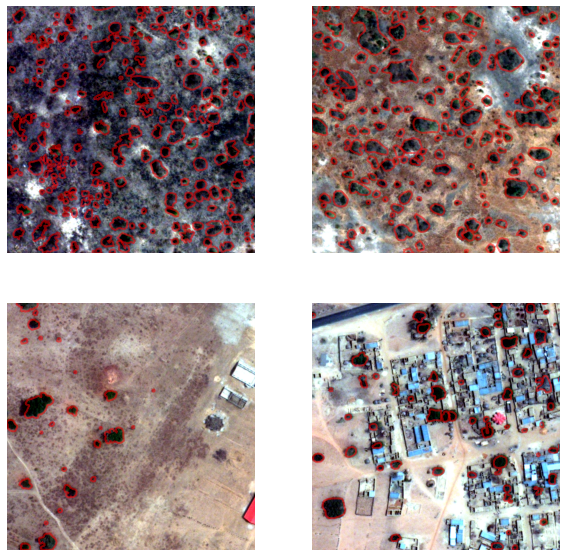

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i in range(2):
    for j in range(2):
        ax = axes[i][j]
        img_id = img_ids[2*i+j]
        rgb_img = data_reader.get_img(img_id, '3')
        processed_rgb_img = process_rgb_img_for_visualisation(rgb_img)
        ax.imshow(processed_rgb_img, extent=(0, 1, 1, 0), origin='upper')
        # plotting trees on top
        multipoly = data_reader.get_multipoly(img_id)
        xmax, ymin = data_reader.get_xmax_ymin(img_id)
        # scaling polygon co-ordinates to agree with image
        multipoly = affinity.scale(
            multipoly, xfact=1/xmax, yfact=1/ymin, origin=(0, 0, 0)
            )  
        for poly in multipoly:
            poly_patch = PolygonPatch(
                poly, 
                alpha=0.5, edgecolor='r', linewidth=2., fill=False
                )
            ax.add_patch(poly_patch)
        ax.set_axis_off()
        ax.set_xlim([0, 0.2])
        ax.set_ylim([0, 0.2])

fig.show()

# Manual Feature Engineering

A bit of research into the field of remote sensing revealed that there are so-called 'indices' which help to identify certain objects on the ground, e.g. trees, buildings, water. These indices are functions of the pixel intensities at different channels. I view them as nothing more than manually constructed features. They are constructed using knowledge of the absorption/reflectance properties of certain classes of objects, with respect to particular spectral bands.

Here's an example. The Normalized Difference Vegetation Index (NDVI) is constructed according to the following formula:

$$\textrm{NDVI} = \frac{NIR - RED}{NIR + RED}$$

where NIR refers to the Near Infra-Red band. This index helps to identify vegetation (in particular, trees) by leveraging the fact that vegetation has high reflectance in the NIR band but low reflectance in the Red band. So, vegetation is expected to have high values of NDVI (1 being the highest possible).

In my analysis, I use 5 such indices: NDVI, Normalized Difference Water Index (NDWI), Built-Up Index (BUI), Canopy Chlorophyll Content Index (CCCI), and Soil-Adjusted Vegetation Index (SAVI). I don't go into detail on them here - there's plenty of material on Google. In choosing these indices, I was looking for anything that will help identify particular objects: be it trees, or buildings, or water. This will help my model identify trees and distinguish them from other types of objects.


## Visualising NDVI

Below, I visualise the NDVI index for 4 randomly chosen 200m x 200m patches. On the right are plots of NDVI, on the left are the (adjusted) RGB images.

In [0]:
np.random.seed(1)
img_ids = np.random.choice(data_reader.img_ids, 4, replace=False)

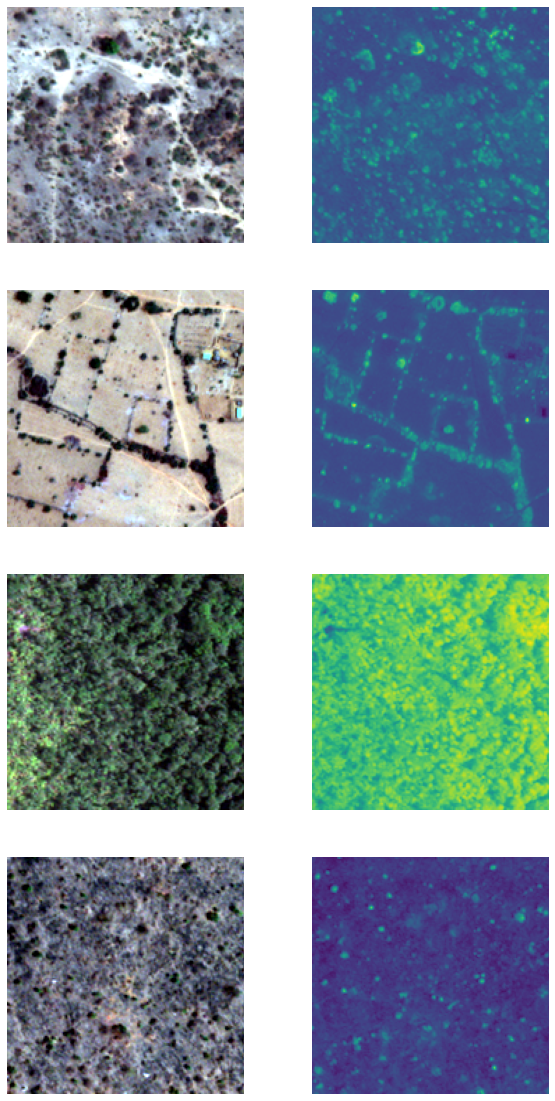

In [10]:
fig, axes = plt.subplots(4, 2, figsize=(10, 20))

for i in range(4):
    img_id = img_ids[i] 
    m_img = data_reader.get_img(img_id, 'M')
    # plotting RGB image
    ax_rgb = axes[i][0]
    rgb_img = m_img[:, :, [4, 2, 1]]  # 4, 2, 1 correspond to R, G, B
    processed_rgb_img = process_rgb_img_for_visualisation(rgb_img)
    ax_rgb.imshow(processed_rgb_img, extent=(0, 1, 1, 0), origin='upper')
    ax_rgb.set_axis_off()
    ax_rgb.set_xlim([0, 0.2])
    ax_rgb.set_ylim([0, 0.2])
    # constructing and plotting NDVI
    red = m_img[:, :, 4]  # the Red band of the Multispectral image
    nir1 = m_img[:, :, 6]  # the Near Infra-Red 1 band 
    red = red.astype(np.float32)
    nir1 = nir1.astype(np.float32)
    ndvi = (nir1 - red)/(nir1 + red)  
    ax_ndvi = axes[i][1]
    ax_ndvi.imshow(ndvi, extent=(0, 1, 1, 0), origin='upper')
    ax_ndvi.set_axis_off()
    ax_ndvi.set_xlim([0, 0.2])
    ax_ndvi.set_ylim([0, 0.2])

fig.show()

NDVI sure seems like a powerful identifier of trees!

# Processing Data

In this section, I provide a class for processing the raw data into a form ready to be input into my model. The processing is done as follows:

*   I resize the Multispectral ('M') and SWIR ('A') images to the size 900 x 900. 
*   Then, I collect them into a single image of 16 channels. I normalise these channels to take on values in the range [0, 1].
*   I add 5 more channels, corresponding to the 5 indices discussed in the prior section. 
*   I split this mega-image into 9 patches of size 300 x 300 each. The splitting is done in a left-to-right, top-to-bottom fashion, so that the 0th patch is the top-left 300 x 300 corner, and the 8th patch is the bottom-right 300 x 300 corner.
*   For the train patches, I construct *binary masks* indicating where the trees are. These are 300 x 300 boolean arrays, with 1s indicating the pixels corresponding to trees. These will serve as the *targets* or *responses* for my model to predict.

The first 16 channels correspond to the following spectral bands, in order from 0 to 15:

Coastal, Blue, Green, Yellow, Red, RedEdge, NIR1 (Near Infra-Red 1), NIR2, SWIR1 (Short-Wave Infra-Red 1), SWIR2, ..., SWIR8.

After this processing, there are 9 x 25 = 225 train 'images' and 9 x 425 = 3825 test 'images', accessible via the .get_processed_imgs() method. The masks for the training images are obtained via the .get_masks() method.

In [0]:
class DataProcessor(DataReader):

    def __init__(self, 
                 raw_data_dir='/content/drive/My Drive/tree_detection',
                 train_imgs_dir='/content/drive/My Drive/tree_detection/' \
                                'processed_data/train_images2',
                 masks_dir='/content/drive/My Drive/tree_detection/'\
                            'processed_data/masks2'):
        """
        Class to process raw data.

        Parameters
        ----------
        root_dir : str
            Path to the root directory containing the raw data.
        train_imgs_dir : str
            Path to the directory in which to store the train images.
        masks_dir : str
            Path to the directory in which to store the binary masks for the
            train images. Should be distinct from train_imgs_dir.
        """
        super().__init__(raw_data_dir)
        self.train_imgs_dir = train_imgs_dir
        self.masks_dir = masks_dir

    def get_mask(self, img_id, H=900, W=900):
        """
        Produce binary tree mask for a specified 1km x 1km region.

        Parameters
        ----------
        img_id : str
            8-character ID characterising the 1km x 1km region.
        H : int
            Height (in pixels) of mask.
        W : int
            Width (in pixels) of mask.

        Returns
        -------
        mask : numpy.ndarray
            Boolean array of shape (H, W) with 1s representing tree pixels and 
            0s non-tree pixels.
        """
        xmax, ymin = self.get_xmax_ymin(img_id)
        multipoly = self.get_multipoly(img_id)
        # scaling polygon co-ordinates according to the Kaggle challenge 
        # description
        multipoly = affinity.scale(
            multipoly, 
            xfact=(W**2)/(W+1) * 1/xmax, 
            yfact=(H**2)/(H+1) * 1/ymin, 
            origin=(0, 0, 0)
            )  
        # initialising mask
        mask = np.zeros((H, W), dtype=np.uint8)
        exterior_coords_list = []
        interior_coords_list = []
        for poly in multipoly:
            exterior_coords = np.round(
                np.array(list(poly.exterior.coords))
            ).astype(np.int32)
            exterior_coords_list.append(exterior_coords)
            for interior in poly.interiors:
                interior_coords = np.round(
                    np.array(list(interior.coords))
                ).astype(np.int32)
                interior_coords_list.append(interior_coords)
        cv2.fillPoly(mask, exterior_coords_list, 1)
        cv2.fillPoly(mask, interior_coords_list, 0)
        mask = mask.astype(bool) 
        return mask

    def split_array(self, array, patch_len=300):
        """
        Split array of shape (H, W, ...) into patch_len x patch_len patches,
        truncating these patches at the edges of the image. Patches are 
        constructed from top-left to bottom-right in a row-first fashion.

        Parameters
        ----------
        array : numpy.ndarray with ndim >= 2
            Array to be split.
        patch_len : int
            See above explanation.

        Returns
        -------
        patches : list of numpy.ndarray
            List of arrays representing the patches formed by splitting the 
            array.
        """
        H, W = array.shape[0], array.shape[1]
        h_list = list(range(0, H, patch_len)) + [H]
        w_list = list(range(0, W, patch_len)) + [W]
        patches = []
        for i in range(len(h_list) - 1):
            h_start = h_list[i]
            h_end = h_list[i+1]
            for j in range(len(w_list) - 1):
                w_start = w_list[j]
                w_end = w_list[j+1]
                patch = array[h_start:h_end, w_start:w_end]
                patches.append(patch)
        return patches
    
    def get_processed_img(self, img_id):
        """
        Produce 21-channel processed 'image' for specified 1km x 1km region.

        Parameters
        ----------
        img_id : str
            8-character ID characterising the 1km x 1km region.

        Returns
        -------
        processed_img : numpy.ndarray
            Array of shape (21, 900, 900).
        """
        img_shape = (900, 900)
        m_img = cv2.resize(
            self.get_img(img_id, 'M'), img_shape
            )
        swir_img = cv2.resize(
            self.get_img(img_id, 'A'), img_shape
            )
        # 8 Multispectral channels, 8 SWIR channels, 5 indices
        processed_img = np.zeros(
            (img_shape[0], img_shape[1], 8 + 8 + 5), dtype=np.float32
            )
        for i in range(8):
            processed_img[:, :, i] = m_img[:, :, i]
        for i in range(8):
            processed_img[:, :, 8+i] = swir_img[:, :, i]
        # defining channels used in constructing the indices
        coastal = processed_img[:, :, 0]
        green = processed_img[:, :, 2]
        red = processed_img[:, :, 4]
        rededge = processed_img[:, :, 5]
        nir1 = processed_img[:, :, 6]
        nir2 = processed_img[:, :, 7]
        swir1 = processed_img[:, :, 8]
        # constructing indices
        ndvi = (nir1 - red)/(nir1 + red)
        ndwi = (coastal - nir2)/(coastal + nir2)
        bui = (coastal - rededge)/(coastal + rededge)
        ccci = (swir1 - rededge)/(swir1 + rededge) * (swir1 + red)/(swir1 - red)
        savi = (nir1 - red)*(1 + 0.5)/(nir1 + red + 0.5)
        processed_img[:, :, 16] = ndvi
        processed_img[:, :, 17] = ndwi
        processed_img[:, :, 18] = bui
        processed_img[:, :, 19] = ccci
        processed_img[:, :, 20] = savi
        # normalising M and SWIR channels
        processed_img[:, :, :8] = processed_img[:, :, :8]/(2**11)
        processed_img[:, :, 8:16] = processed_img[:, :, 8:16]/(2**14)
        return processed_img

    def get_processed_imgs(self, img_id, patch_nums):
        """
        Retrieve processed images ready to be input into model. 

        Parameters
        ----------
        img_id : str
            8-character ID characterising the 1km x 1km region.
        patch_nums : list of int
            List of integers between 0 and 8 (inclusive) identifying the 
            patches of the region to retrieve.

        Returns
        -------
        imgs : list of numpy.ndarray
            List of arrays of shape (300, 300, 21), corresponding to the 
            images specified by img_id and patch_nums.
        """
        img = self.get_processed_img(img_id)
        patches = self.split_array(img)
        imgs = [patches[patch_num] for patch_num in patch_nums]
        return imgs

    def get_masks(self, img_id, patch_nums):
        """
        Retrieve binary masks ready to serve as targets for model.

        Parameters
        ----------
        img_id : str
            8-character ID characterising the 1km x 1km region.
        patch_nums : list(int)
            List of integers between 0 and 8 (inclusive) identifying the 
            patches of the region whose masks are to be retrieved.

        Returns
        -------
        masks : list of numpy.ndarray
            List of arrays of shape (300, 300), corresponding to the masks
            specified by img_id and patch_nums.
        """
        assert img_id in self.train_img_ids, 'img_id must be a train img_id'
        mask = self.get_mask(img_id, H=900, W=900)
        mask_patches = self.split_array(mask)
        masks = [mask_patches[patch_num] for patch_num in patch_nums]
        return masks

In [0]:
data_processor = DataProcessor()

# Neural Network

Finally. The best bit of any machine learning project: constructing and training a model. In this case, a neural network.



## The Problem

In earlier sections, I've alluded to the problem setup. Here, I give a concrete description. 

We are in the supervised learning setting. The inputs to the model are images of shape 300 x 300 x 21 (actually, 21 x 300 x 300, because I'll be using PyTorch, but you get the point). The outputs will be of shape 300 x 300 (or 1 x 300 x 300). Each number in this output array will be between 0 and 1 and will represent the probability of the pixel being a tree pixel. We then interpret everything greater than 0.5 to mean 'tree pixel' and everything below to mean 'non-tree pixel'. 

The *targets* (i.e. the target outputs for the train images) are the binary masks corresponding to the train images. The loss function is the standard binary cross-entropy, applied individually over the array elements and then summed. 

## Training

I randomly choose 25 of the 225 train images to form a *validation set*. The remaining 200 images are used for training. During training, I keep an eye on the accuracy of the model on the validation set (defined as the % of pixels among the validation images whose class (i.e. tree vs non-tree) is correctly identified). Training is continued until the validation accuracy plateaus or begins to decrease - in the former case, the learning rate is increased. The model is saved at those epochs where the validation accuracy reaches a new high. I don't do any batching, because I only have 200 images with which to train, which can easily fit in RAM. That said, I know that batching isn't just a technique for dealing with massive amounts of data - it also helps with mitigating overfitting. 

Note: In my impatience to get something working, I didn't bother to figure out how to automate a lot of this stuff. For example, I manually changed the learning rate when I deemed it appropriate to do so. 

## Architecture

All of my models were fully convolutional networks which preserve the spatial shape of the inputs. That is, an input of spatial shape 300 x 300 will yield an output of spatial shape 300 x 300. 

I tried various network architectures, starting simple and then increasing complexity by increasing depth and the number of filters in the convolutional layers. I present only the final model here - I stopped increasing complexity when the validation error didn't improve much. To be honest, I could have experimented a lot more - but I was happy enough with the end result that I didn't. Interestingly, the biggest improvement came when I increased the kernel sizes of my filters from 3 x 3 to 5 x 5.

My final model downsamples via strided convolutions, then passes the data through several convolutional layers at a low spatial resolution, and then upsamples via transpose convolutional (a.k.a. 'deconvolutional') layers. It correctly classified 94.164% of validation pixels. To put this into context, about ~88% of the pixels are non-tree pixels, so guessing everything to be non-tree gives us an accuracy of 88%. 70.564% of tree pixels were classified as such, and 97.517% of non-tree pixels were classified as such.

I'm sure there must be a way to display neural network architectures in a nice way. For the time being, I can only offer the bare PyTorch code below. That said, PyTorch is intuitive enough that it should be easy to understand what's going on.

The network is defined as follows:

In [0]:
# defining network architecture
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            21, 14, 5, padding=2
        )  # 14 x 300 x 300
        self.conv2 = nn.Conv2d(
            14, 14, 5, padding=2, stride=2
        )  # 14 x 150 x 150
        self.conv3 = nn.Conv2d(
            14, 21, 5, padding=2, stride=2
        )  # 21 x 75 x 75
        self.conv4 = nn.Conv2d(
            21, 21, 5, padding=2, stride=1
        )  # 21 x 75 x 75
        self.conv5 = nn.Conv2d(
            21, 21, 5, padding=2, stride=1
        )  # 21 x 75 x 75
        self.conv6 = nn.Conv2d(
            21, 21, 5, padding=2, stride=1
        )  # 21 x 75 x 75
        self.tconv7 = nn.ConvTranspose2d(
            21, 14, 4, padding=1, stride=2
        )  # 14 x 150 x 150
        self.tconv8 = nn.ConvTranspose2d(
            14, 21, 4, padding=1, stride=2
        )  # 21 x 300 x 300 
        self.conv9 = nn.Conv2d(
            21, 1, 5, padding=2, stride=1
        )  # 1 x 300 x 300

    def forward(self, x):
        x = self.conv1(x)  
        x = F.relu(x)  
        x = self.conv2(x)  
        x = F.relu(x)
        x = self.conv3(x) 
        x = F.relu(x)
        x = self.conv4(x) 
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.tconv7(x)  
        x = F.relu(x)
        x = self.tconv8(x)  
        x = F.relu(x)
        x = self.conv9(x)  
        return x

Loading the model I've trained.

In [0]:
# loading trained model
net = Net()
net = net.to('cuda')
net = torch.load('/content/drive/My Drive/tree_detection/model5')



---

## An Aside: Training Code

Below, I present some of the code I wrote for training. It's rudimentary, and definitely not the best way to train these things. I use the GPU on Google Colab for training.

In [0]:
# using the Adam optimizer; lr is the learning rate
optimizer = optim.Adam(net.parameters(), lr=0.001) 

In [0]:
# specifying the loss function
# can give more weight to identifying tree pixels (positive class) correctly
# by increasing the number 1
bceloss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(1.))

In [0]:
# collecting all training data into one list
num = 0
train_data = []
for img_id in data_processor.train_img_ids:
    imgs = data_processor.get_processed_imgs(
        img_id, [0, 1, 2, 3, 4, 5, 6, 7, 8]
        )
    masks = data_processor.get_masks(
        img_id, [0, 1, 2, 3, 4, 5, 6, 7, 8]
    )
    for i in range(9):
        # changing shapes to 21 x 300 x 300 and 1 x 300 x 300 
        # (PyTorch demands this)
        img = np.rollaxis(imgs[i], 2, 0)
        mask = np.reshape(masks[i], (1, 300, 300))
        train_data.append((img, mask))
        num += 1

In [0]:
# shuffling training image numbers (0-224 inclusive)
np.random.seed(1)
img_nums = list(range(225))
np.random.shuffle(img_nums)

# first 200 of the shuffled image numbers make up the actual train set (on which
# the model will be trained), remaining 25 make up the val set

train_X = []; train_y = []
for img_num in img_nums[:200]:
    img = train_data[img_num][0]
    mask = train_data[img_num][1]
    train_X.append(img); train_y.append(mask)
train_X = np.array(train_X)  # shape (200, 21, 300, 300)
train_X = torch.from_numpy(train_X.astype(np.float32))
train_y = np.array(train_y)  # shape (200, 1, 300, 300)
train_y = torch.from_numpy(train_y.astype(np.float32))
train_X, train_y = train_X.cuda(), train_y.cuda()  

val_X = []; val_y = []
for img_num in img_nums[200:]:
    img = train_data[img_num][0]
    mask = train_data[img_num][1]
    val_X.append(img); val_y.append(mask)
val_X = np.array(val_X)  # shape (25, 21, 300, 300)
val_X = torch.from_numpy(val_X.astype(np.float32))
val_y = np.array(val_y)  # shape (25, 1, 300, 300)
val_X = val_X.cuda()  # don't need val_y on GPU

del(train_data)

In [0]:
# training - assuming everything's on GPU
# best_val_acc = 0  # this tracks the highest accuracy on the val set 
# # observed so far
model_path = 'model'  # location (path) to save model
epochs = 0
for epoch in range(epochs):
    net.zero_grad()
    out = net(train_X)
    loss = bceloss(out, train_y)
    loss.backward()  # backprop
    optimizer.step() # weight update
    if epoch % 10 == 0:
        print(f'epoch {epoch}')
        print(f'training loss: {round(float(loss.cpu().detach().numpy()), 3)}')
        with torch.no_grad():
            out = (torch.sigmoid(net(val_X)) > 0.5) * 1.0
            out = out.cpu().detach().numpy()
            val_acc = (out == val_y).sum()/(25 * 300 * 300)
            # val_(non)tree_acc is % of (non)tree pixels that are correctly 
            # classified
            val_tree_acc = (val_y * out).sum()/val_y.sum()
            val_nontree_acc = ((val_y == 0) * (1-out)).sum()/(val_y == 0).sum()
            print(f'val accuracy: {round(val_acc, 3)}')
            print(f'val tree accuracy: {round(val_tree_acc * 100, 3)}')
            print(f'val nontree accuracy: {round(val_nontree_acc * 100, 3)}\n')
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(net, model_path)
            print('saved model')



---







## Results

Displaying ground truth and prediction for 5 randomly selected validation images.

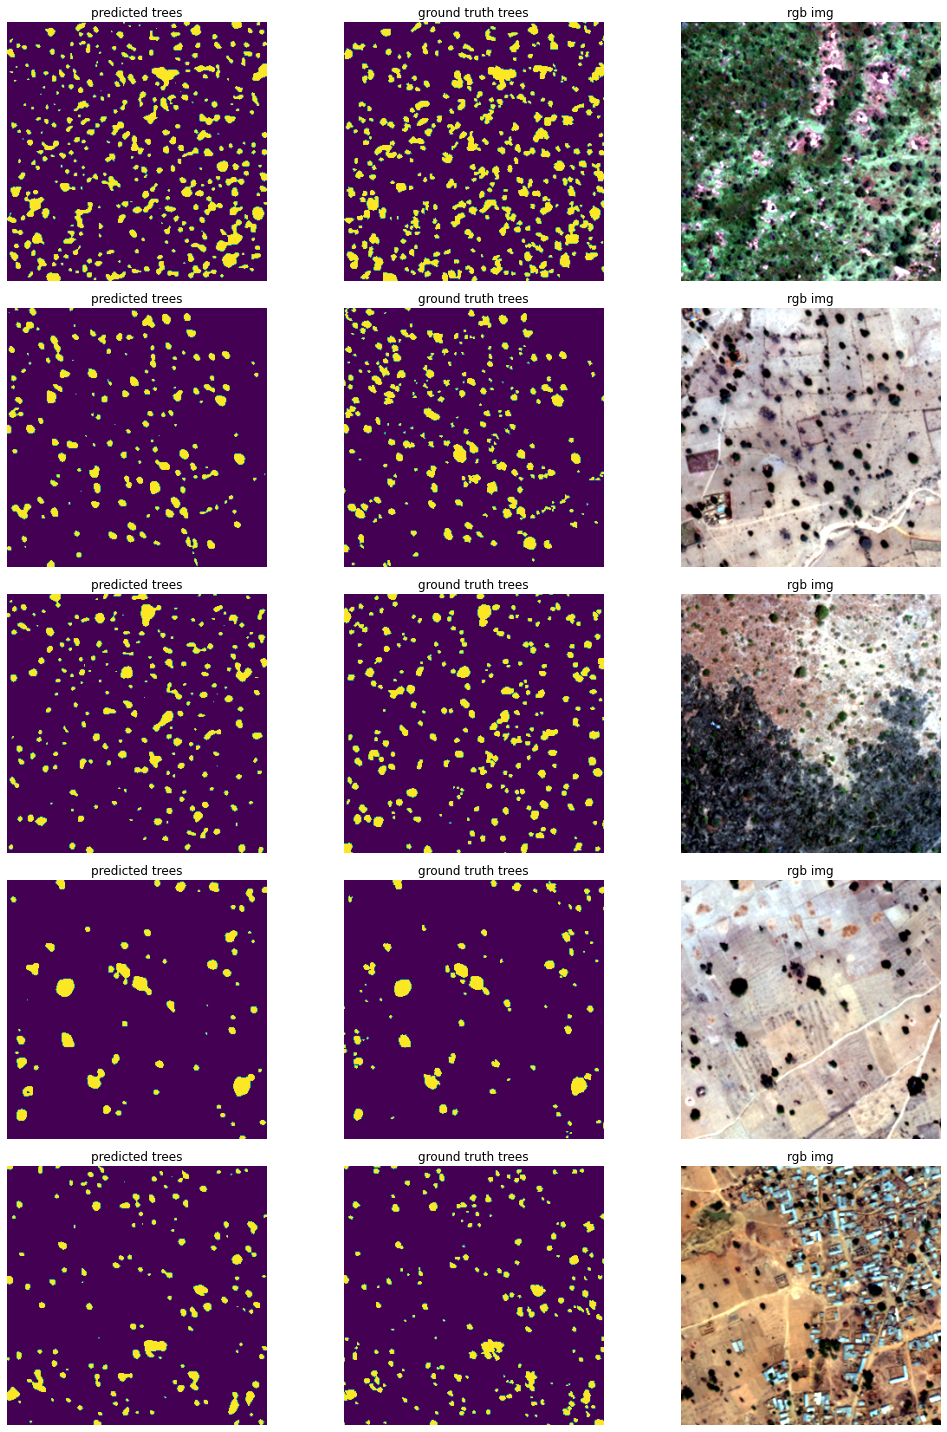

In [20]:
fig, axes = plt.subplots(5, 3, figsize=(15, 20))

with torch.no_grad():
    pred = torch.sigmoid(net(val_X))
    pred = (pred.cpu().detach().numpy() > 0.5) * 1
val_X_numpy = val_X.cpu().detach().numpy()

# randomly choosing 5 of the 25 validation images
np.random.seed(1)
val_img_nums = np.random.choice(list(range(25)), 5, replace=False)
for i, img_num in enumerate(val_img_nums):
    pred_y = pred[img_num][0]
    true_y = val_y[img_num][0]
    rgb_img = np.rollaxis(val_X_numpy[img_num][[4, 2, 1]], 0, 3)
    processed_rgb_img = process_rgb_img_for_visualisation(rgb_img)
    axes[i][0].imshow(pred_y)
    axes[i][0].set_title('predicted trees')
    axes[i][1].imshow(true_y)
    axes[i][1].set_title('ground truth trees')
    axes[i][2].imshow(processed_rgb_img)
    axes[i][2].set_title('rgb img')
    for j in range(3):
        axes[i][j].set_axis_off()

fig.tight_layout()
fig.show()

Displaying predictions for 5 randomly chosen test images.

In [0]:
# randomly choosing 5 test images
np.random.seed(0)
test_img_ids = np.random.choice(
    data_processor.test_img_ids, 5, replace=False
    )
test_img_patch_nums = np.random.choice(
    [0, 1, 2, 3, 4, 5, 6, 7, 8], 5, replace=True
    )
test_imgs = [
             data_processor.get_processed_imgs(img_id, [patch_num])[0] for 
             (img_id, patch_num) in list(zip(test_img_ids, test_img_patch_nums))
             ] 

In [0]:
# passing test images to model
test_X = [np.rollaxis(test_img, 2, 0) for test_img in test_imgs]
test_X = torch.tensor(np.array(test_X)).cuda()
with torch.no_grad():
    pred = torch.sigmoid(net(test_X))
    pred = (pred.cpu().detach().numpy() > 0.5) * 1

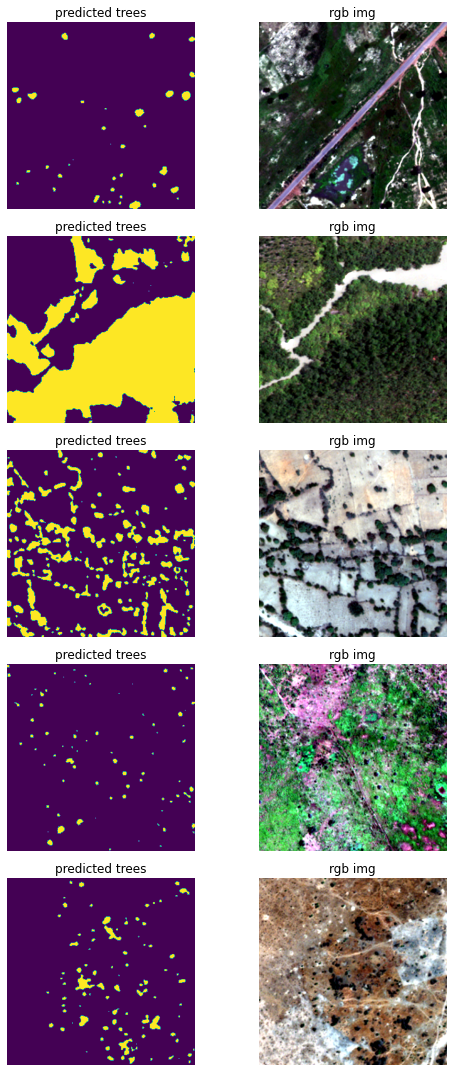

In [23]:
# plotting
fig, axes = plt.subplots(5, 2, figsize=(8, 15))

for i, test_img in enumerate(test_imgs):
    axes[i][0].imshow(pred[i][0])
    axes[i][0].set_title('predicted trees')
    rgb_img = test_img[:, :, [4, 2, 1]]
    processed_rgb_img = process_rgb_img_for_visualisation(rgb_img)
    axes[i][1].imshow(processed_rgb_img)
    axes[i][1].set_title('rgb img')
    for j in range(2):
        axes[i][j].set_axis_off()

fig.tight_layout()
fig.show()